In [1172]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16})
from numba import jit, njit, vectorize
import time
from IPython.core.debugger import set_trace
from scipy.signal import savgol_filter

## Defining functions that we need:

In [907]:
@vectorize#By far the quickest of the three for vectors
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

#Athuga betur hvernig ég á að díla við að deila með núlli þegar Coulomb víxlverkun til staðar
@jit(nopython=True)
def TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    if abs(r_12) <= 1e-12:
        return 0
    else:
        return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha + 1/r_12
    
#Trial energy for the seconds trial wave function
@jit(nopython=True)
def TrialEnergy2JIT(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    TrialEnergy1 = TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2)
    if abs(r_12) <= 1e-12:
        return 0
    else:
        temp1 = 1/(2*(1 + beta*r_12)**2)
        temp2 = alpha*omega*r_12
        temp3 = 1/(2*((1 + beta*r_12))**2)
        temp4 = (2*beta)/(1 + beta*r_12)
        TrialEnergy2Partial = temp1*(temp2 - temp3 - 2/r_12 + temp4)
        return TrialEnergy1 + TrialEnergy2Partial

#ATH! Should there be a -2/r_12 or a plus, wierd to have a minus as that reduces energy when electrons near each other

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

@jit
def TrialWaveFunction2(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    if (beta*r_12 < -1+1e-12) and (beta*r_12 > -1-1e-12):#So that not division by zero
        return 0
    else:
        return np.exp(-alpha*omega*(r1**2 + r2**2)/2)*np.exp(r_12/(2*(1 + beta*r_12)))

#Function to calculate the potential energy at each position for different omega
@jit
def PotentialEnergy1(omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    temp1 = 0.5*(omega**2)*(r1**2)
    temp2 = 0.5*(omega**2)*(r2**2)
    temp3 = 1/r_12
    return temp1 + temp2 + temp3

@jit#Without the Coulomb interaction
def PotentialEnergy2(omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    temp1 = 0.5*(omega**2)*(r1**2)
    temp2 = 0.5*(omega**2)*(r2**2)
    return temp1 + temp2

In [910]:
print(PotentialEnergy1(2,1,0,0,0,1,1))

6.577350269189627


In [912]:
alpha = 0.25
beta = 0
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,2,3,0,0,15,0)
print(trialEnergyTemp)
x1 = 0
y1 = 0
z1 = 0
x2 = 0
y2 = 0
z2 = 0.5
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp)
trialEnergyTemp1 = TrialEnergy2JIT(alpha,beta,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp1)

0.75
112.39469949365268
2.398588562373095
0.8227633476483185


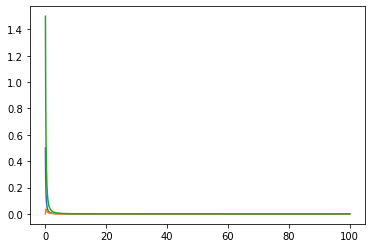

In [504]:
#Trying to plot just the addon due to trial wave function 2 to the trial energy
alpha = 1
omega = 1
r_12 = 4
beta = np.linspace(0,100,1000)
TrialEnergy2Partial = (1/(2*(1 + beta*r_12)**2))
TrialTemp = 2*beta/(1 + beta*r_12)*TrialEnergy2Partial
TrialEnergyTrue = TrialEnergy2Partial*(alpha*omega*r_12 - 1/(2*(1+beta*r_12)**2) - 2/r_12 + (2*beta/(1 + beta*r_12)))
#(alpha*omega*r_12 - (1/2*(1+beta*r_12)**2) - 2/r_12 + (2*beta/(1 + beta*r_12)))
#plotting
fig0,ax0 = plt.subplots()
ax0.plot(beta,TrialEnergy2Partial)
ax0.plot(beta,TrialTemp)
ax0.plot(beta,TrialEnergyTrue)

## Monte Carlo and Metropolis algo:

In [868]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Probability ratio for the second trial wave function
@jit
def ProbRatio2(Rold,Rnew,alpha,beta,omega):#Rold and Rnew as an array
    new = TrialWaveFunction2(alpha,beta,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction2(alpha,beta,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part for the first trial wave function
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

#Metropolis test for the second trial wave function
@jit
def Metropolis2(Rold,Rnew,alpha,beta,omega):
    Acceptance = False
    probRatio = ProbRatio2(Rold,Rnew,alpha,beta,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [7]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


**First Monte Carlo with trial wave function 1 and without Coulomb interaction:**

In [937]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    PotentialEnergy = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJIT(alpha,omega,r1,r2)
            PotentialTemp = PotentialEnergy2(omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            PotentialEnergy += PotentialTemp
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    AveragePotentialEnergy = PotentialEnergy/MCCycles/6
    #AveragePotentialEnergy = PotentialEnergy2(omega,x1,y1,z1,x2,y2,z2)
    Variance = AverageEnergySquared - AverageEnergy**2
    
    return AverageEnergy, CounterAccept/6, Variance, AveragePotentialEnergy

**Then MC for trial wave function 1 with Coulomb interaction: ATH LAGA ÞETTA FALL!!**

In [914]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarloCoulomb(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    ElectronDistance = 0
    PotentialEnergy = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJITwithCoulomb(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            if np.isnan(EnergyTemp):
                print("Error, the Energy is nan, cycle numner:",i,l)
                break
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2
            #Potential Energy Term
            PotentialEnergyTemp = PotentialEnergy1(omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            PotentialEnergy += PotentialEnergyTemp
            #Updating the expectationValue of the distance between the two electrons
            ElectronDistance += np.sqrt((Rold[0]-Rold[3])**2 + (Rold[1]-Rold[4])**2 + (Rold[2]-Rold[5])**2)
            

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    AveragePotentialEnergy = PotentialEnergy/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    ElectronDistanceAverage = ElectronDistance/MCCycles/6
    
    return AverageEnergy, int(CounterAccept/6), Variance, ElectronDistanceAverage, AveragePotentialEnergy

**Then Monte Carlo for the second trial wave function:**

In [915]:
@jit(nopython=True)
def MonteCarlo2(MCCycles,omega,alpha,beta,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    ElectronDistance = 0
    PotentialEnergy = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis2(Rold,Rnew,alpha,beta,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergy2JIT(alpha,beta,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            if np.isnan(EnergyTemp):
                print("Error, the Energy is nan, cycle numner:",i,l)
                break
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2
            PotentialEnergyTemp = PotentialEnergy1(omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            PotentialEnergy += PotentialEnergyTemp
            #Updating the expectationValue of the distance between the two electrons
            ElectronDistance += np.sqrt((Rold[0]-Rold[3])**2 + (Rold[1]-Rold[4])**2 + (Rold[2]-Rold[5])**2)
            

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    AveragePotentialEnergy = PotentialEnergy/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    ElectronDistanceAverage = ElectronDistance/MCCycles/6
    
    return AverageEnergy, int(CounterAccept/6), Variance, ElectronDistanceAverage, AveragePotentialEnergy

## Trial of the MC calculations:

1.5
265326.3333333333
Energy: 8.17519651195193 Variance: 15.578453328325779 Potential energy: 7.500215947200288
1.5
232618.33333333334
Energy: 5.620225919603572 Variance: 3.789346300330095 Potential energy: 4.493634559471661
1.5
209357.66666666666
Energy: 4.787754469639846 Variance: 0.8969108015323748 Potential energy: 3.21128327380511
1.5
191295.83333333334
Energy: 4.52505525821492 Variance: 0.07479559067997954 Potential energy: 2.5002908327086195
1.5
183877.83333333334
Energy: 4.5 Variance: 0.0 Potential energy: 2.248799287209174
1.5
170663.16666666666
Energy: 4.57186630905455 Variance: 0.22925261261913832 Potential energy: 1.8821220248763229
1.5
159857.0
Energy: 4.75939539633429 Variance: 0.8085192087002078 Potential energy: 1.6047964621514204
1.5
150795.5
Energy: 5.003814000078948 Variance: 1.593749114468725 Potential energy: 1.4078115384105259
1.5
142949.66666666666
Energy: 5.296100725837163 Variance: 2.6079209611000316 Potential energy: 1.251740747394168
1.5
135784.5
Energy: 5.62

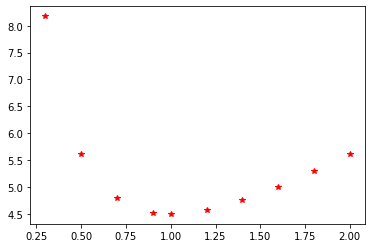

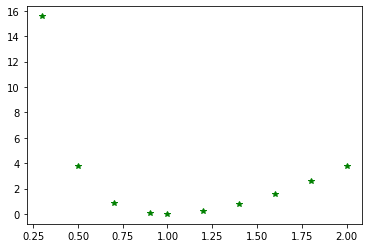

In [883]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
fig0, ax0 = plt.subplots()
omegaTrial = 1.5
for alphaTemp in alpha:
    Energy, Counter, Variance, PotEnergy = MonteCarlo(int(4e5),omegaTrial,alphaTemp,3.8)
    print(Counter)
    print("Energy:",Energy,"Variance:",Variance,"Potential energy:",PotEnergy)
    ax.plot(alphaTemp,Energy,'r*')
    ax0.plot(alphaTemp,Variance,'g*')

**Device a way to find the optimal step length for each alpha so that acceptance rate is around 50%**

**Algorithm that takes care of finding the step size such that 50 \% acceptance rate in a brute force way:**

In [938]:
@jit
def FindStepsize(stepsize,alpha,omega):
    M = len(alpha)
    StepSize = np.zeros(M)
    counter = 0
    for i in alpha:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance, PotEnergy = MonteCarlo(1000,omega,i,l)
            if (Counter >= 400) and (Counter <= 600):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

@jit
def FindStepsize2(stepsize,alpha,beta,omega):
    MCCycles = 10000
    M = len(beta)
    StepSize = np.zeros(M)
    counter = 0
    for i in beta:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(1000,omega,alpha,i,l)
            if (Counter >= 480) and (Counter <= 520):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

#Function that finds the minimal energy in terms of either alpha or beta
#as well as finding the electron distance at that minimum
def FindMinimalEnergy(EnergyTotal,ElectronDistance,PotentialEnergyTotal,alpha,beta,VarChoice):
    #Variable VarChoice decides which variable we are trying to find a minimum at, alpha or beta
    MinimalEnergy = np.min(EnergyTotal)
    MinimalEnergyIndex = np.where(EnergyTotal == MinimalEnergy)[0][0]#Index for minimal energy
    if VarChoice == "alpha":
        alphaMinimal = alpha[MinimalEnergyIndex]
        electronDistanceMinimalEnergy = ElectronDistance[MinimalEnergyIndex]
        PotentialEnergyMinimum = PotentialEnergyTotal[MinimalEnergyIndex]
        return MinimalEnergy, electronDistanceMinimalEnergy, alphaMinimal, PotentialEnergyMinimum
    elif VarChoice == "beta":
        betaMinimal = beta[MinimalEnergyIndex]
        electronDistanceMinimalEnergy = ElectronDistance[MinimalEnergyIndex]
        PotentialEnergyMinimum = PotentialEnergyTotal[MinimalEnergyIndex]
        return MinimalEnergy, electronDistanceMinimalEnergy, betaMinimal, PotentialEnergyMinimum
    else:
        assert("Please state wheter to find minimal with regards to beta or alpha")

In [940]:
#Trial
stepsize = np.arange(0,10,0.05)
alpha = np.arange(0.2,2,0.2)
print(alpha)
StepSize = FindStepsize(stepsize,alpha,1)
#Trial for second wave function
beta = np.arange(0.2,2,0.2)
StepSize2 = FindStepsize2(stepsize,0.85,beta,1)
print(StepSize2)

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]
[4.85  4.75  4.575 4.625 4.575 4.6   4.575 4.6   4.575]


In [941]:
print(StepSize)

[8.5   6.775 5.525 4.825 4.375 3.9   3.65  3.425 3.175]


# 5.c)

**First let's check our calculations without the Coulomb potential and see if we obtain the exact answer:**

In [1134]:
#Monte Carlo calculations for the first trial wave function for more number of different alpha
#first finding the optimal step size for each value of alpha
alpha1 = np.arange(0.2,2,0.05)
stepsize1 = np.arange(0,10,0.05)
StepSize1 = FindStepsize(stepsize1,alpha1,1)
EnergyTotalAnalytical = np.zeros(len(alpha1))
VarianceTotalAnalytical = np.zeros(len(alpha1))
CounterTotalAnalytial = np.zeros(len(alpha1))
PotentialEnergyTotalAnalytical = np.zeros(len(alpha1))
#Then doing calculation for each alpha
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, PotEnergy = MonteCarlo(int(1e6),1,alphaTemp,stepTemp)
    EnergyTotalAnalytical[i] = Energy
    VarianceTotalAnalytical[i] = Variance
    CounterTotalAnalytial[i] = Counter
    PotentialEnergyTotalAnalytical[i] = PotEnergy
    #print(Counter,Energy,Variance)
end = time.time()
print("Measurement took in seconds:",end-start)

Measurement took in seconds: 45.30519366264343


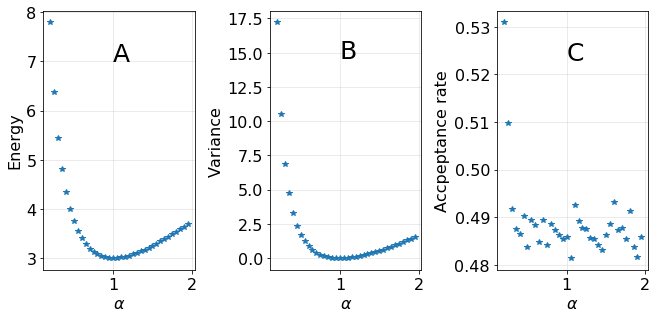

In [1178]:
#better picture
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_axes([0.1, 0.1, 0.3, 0.9])
ax2 = fig.add_axes([0.55, 0.1, 0.3, 0.9])
ax3 = fig.add_axes([1, 0.1, 0.3, 0.9])
#Energy
ax1.plot(alpha1,EnergyTotalAnalytical,'*')
ax1.grid(alpha=0.3)
ax1.set_ylabel("Energy")
ax1.set_xlabel(r"$\alpha$")
ax1.text(1,7,"A",size=25)
#Variance
ax2.plot(alpha1,VarianceTotalAnalytical,'*')
ax2.grid(alpha=0.3)
ax2.set_ylabel("Variance")
ax2.set_xlabel(r"$\alpha$")
ax2.text(1,14.6,"B",size=25)
#Counter
ax3.plot(alpha1,CounterTotalAnalytial/1e6,'*')
ax3.grid(alpha=0.3)
ax3.set_ylabel("Accpeptance rate")
ax3.set_xlabel(r"$\alpha$")
ax3.text(1,0.523,"C",size=25)
#Saving
plt.savefig("SimpleHarmonic2e.png",format="PNG",dpi=300,bbox_inches="tight")

## Then we do the calculations with Coulomb interaction for both trial wave functions. Basing the optimization of paramater $\beta$ on the initial extremum in $\alpha$. We take measurements for three different value of $\omega$, $\omega \in \{0.01,0.5,1\}$

# First with $\omega = 1$:

In [942]:
omega1 = 1
alpha1 = np.arange(0.2,2,0.02)
stepsize1 = np.arange(0,10,0.05)
StepSize1 = FindStepsize(stepsize1,alpha1,omega1)

In [1000]:
print(StepSize1)

[8.45  8.325 8.15  8.025 7.9   7.85  7.575 7.475 7.175 7.025 6.8   6.7
 6.5   6.4   6.175 6.05  6.025 5.875 5.75  5.725 5.55  5.5   5.375 5.325
 5.225 5.125 5.1   5.    4.95  4.925 4.875 4.725 4.725 4.675 4.6   4.6
 4.55  4.5   4.45  4.3   4.3   4.275 4.275 4.2   4.15  4.075 4.15  4.025
 4.    3.975 3.925 3.9   3.9   3.825 3.8   3.8   3.8   3.8   3.75  3.675
 3.575 3.675 3.575 3.55  3.5   3.5   3.475 3.45  3.425 3.45  3.4   3.425
 3.375 3.325 3.35  3.3   3.3   3.225 3.225 3.175 3.2   3.1   3.15  3.15
 3.15  3.15  3.075 3.1   3.05  3.025]


In [943]:
EnergyTotal = np.zeros(len(alpha1))
CounterTotal = np.zeros(len(alpha1))
VarianceTotal = np.zeros(len(alpha1))
ElectronDistanceTotal = np.zeros(len(alpha1))
PotentialEnergyTotal = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(1e6),omega1,alphaTemp,stepTemp)
    EnergyTotal[i] = Energy
    CounterTotal[i] = Counter
    VarianceTotal[i] = Variance
    ElectronDistanceTotal[i] = ElectronDistance
    PotentialEnergyTotal[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 106.16436386108398


In [946]:
#Finding the lowest energy
MinimalEnergy, electDistMinimalEnergy, alphaMinimal, PotEnergyMinimal = FindMinimalEnergy(EnergyTotal,ElectronDistanceTotal,PotentialEnergyTotal,alpha1,1,"alpha")
print("The minimum in energy is:",MinimalEnergy)
print("alpha at that minimum is:",alphaMinimal)
print("This distance between electrons at the mininum is",electDistMinimalEnergy)
print("The potential energy at that position is",PotEnergyMinimal)
#Finding the minimum in variance
MinimalVariance0, electDistMinimalVar0, alphaMinimal0, PotEnergyMinimal0 = FindMinimalEnergy(VarianceTotal,PotentialEnergyTotal,ElectronDistanceTotal,alpha1,1,"alpha")
print("The minimum in variance is:",MinimalVariance0)
print("alpha at that minimum is:",alphaMinimal0)
print("This distance between electrons at the mininum is",electDistMinimalVar0)
print("The potential energy at that position is",PotEnergyMinimal0)

The minimum in energy is: 3.7730542609261843
alpha at that minimum is: 0.8799999999999997
This distance between electrons at the mininum is 1.7011177159618498
The potential energy at that position is 2.452217620256508
The minimum in variance is: 0.257845782416835
alpha at that minimum is: 0.8599999999999997
This distance between electrons at the mininum is 2.4829212385828128
The potential energy at that position is 1.721146679235205


**Plotting:**

Text(0.5, 0, '$\\alpha$')

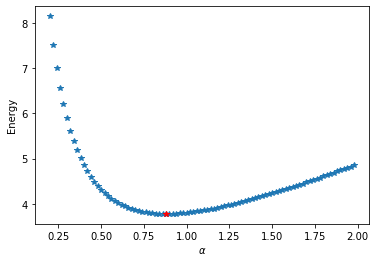

In [947]:
#Energy as a function of variational paramater alpha
fig5_1,ax5_1 = plt.subplots()
ax5_1.plot(alpha1,EnergyTotal,'*')
ax5_1.plot(alphaMinimal,MinimalEnergy,'r*')
ax5_1.set_ylabel("Energy")
ax5_1.set_xlabel(r"$\alpha$")

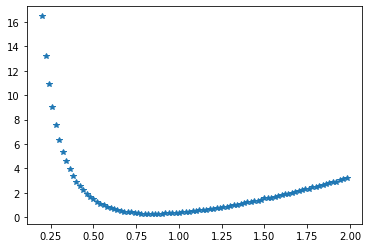

In [948]:
#Variance as a function of variational parameter alpha
fig5_2,ax5_2 = plt.subplots()
ax5_2.plot(alpha1,VarianceTotal,'*')

**Then analysis for the second trial wave function using the optimal $\alpha$ obtained:**

In [736]:
#Setting up range in beta
temp = np.arange(0.4,1.4,0.02)
beta1 = np.arange(0.02,3,0.2)
beta1 = np.concatenate((temp,beta1),axis=0)
beta1 = np.sort(beta1)
print(beta1)

[0.02 0.22 0.4  0.42 0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6
 0.62 0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36
 1.38 1.42 1.62 1.82 2.02 2.22 2.42 2.62 2.82]


In [737]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize2 = FindStepsize2(stepsize,0.88,beta1,1)
print(StepSize2)

[5.  4.8 4.6 4.7 4.5 4.7 4.6 4.6 4.7 4.6 4.6 4.6 4.6 4.5 4.5 4.6 4.6 4.7
 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.4 4.5 4.6 4.5 4.5 4.6 4.5 4.5 4.5 4.6 4.5
 4.4 4.6 4.6 4.4 4.4 4.5 4.4 4.4 4.6 4.5 4.4 4.5 4.5 4.5 4.5 4.5 4.4 4.5
 4.5 4.5 4.5 4.4 4.5 4.5 4.6 4.6 4.6 4.5 4.4]


In [741]:
alpha1_Minimal = 0.86
EnergyTotal2 = np.zeros(len(beta1))
CounterTotal2 = np.zeros(len(beta1))
VarianceTotal2 = np.zeros(len(beta1))
ElectronDistanceTotal2 = np.zeros(len(beta1))
start = time.time()
for i in range(len(beta1)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(5e6),omega1,alpha1_Minimal,beta1[i],4.5)
    EnergyTotal2[i] = Energy
    CounterTotal2[i] = Counter
    VarianceTotal2[i] = Variance
    ElectronDistanceTotal2[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 619.1042504310608


In [758]:
#Finding the minimal energy
MinimalEnergy2, electDistMinimalEnergy2, betaMinimal2 = FindMinimalEnergy(EnergyTotal2,ElectronDistanceTotal2,alpha1_Minimal,beta1,"beta")
print(MinimalEnergy2)
print(betaMinimal2,electDistMinimalEnergy2)
#Filtered
EnergyTotal2Filtered = savgol_filter(EnergyTotal2,window_length=7,polyorder=5)
MinimalEnergy2Filt, electDistMinimalEnergy2Filt, betaMinimal2Filt = FindMinimalEnergy(EnergyTotal2Filtered,ElectronDistanceTotal2,alpha1_Minimal,beta1,"beta")
print("The minimum in energy is:",MinimalEnergy2Filt)
print("Beta at that minimum is:",betaMinimal2)
print("This distance between electrons at that minimum is:",electDistMinimalEnergy2Filt)

3.749869676931379
0.6400000000000002 1.840518118711498
The minimum in energy is: 3.7500587687005495
Beta at that minimum is: 0.6400000000000002
This distance between electrons at that minimum is: 1.8446203427000079


Text(0, 0.5, 'Energy')

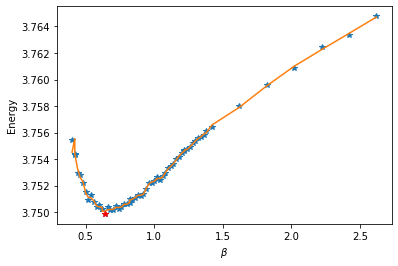

In [743]:
#plotting Energy as a function of Beta
fig5_3,ax5_3 = plt.subplots()
ax5_3.plot(beta1[2:-1],EnergyTotal2[2:-1],'*')
ax5_3.plot(beta1[2:-1],EnergyTotal2Filtered[2:-1])
ax5_3.plot(betaMinimal2,MinimalEnergy2,'r*')
ax5_3.set_xlabel(r"$\beta$")
ax5_3.set_ylabel("Energy")

Text(0, 0.5, 'Variance')

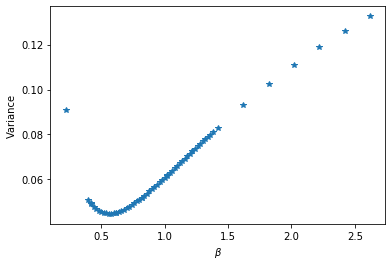

In [746]:
#plotting Variance in Energy as a function of Beta
fig5_4,ax5_4 = plt.subplots()
ax5_4.plot(beta1[1:-1],VarianceTotal2[1:-1],'*')
ax5_4.set_xlabel(r"$\beta$")
ax5_4.set_ylabel("Variance")

## Running again for variation in $\alpha$ with optimal $\beta$

In [1020]:
alpha1_2 = np.arange(0.89,1.005,0.0025)
print(alpha1_2)

[0.89   0.8925 0.895  0.8975 0.9    0.9025 0.905  0.9075 0.91   0.9125
 0.915  0.9175 0.92   0.9225 0.925  0.9275 0.93   0.9325 0.935  0.9375
 0.94   0.9425 0.945  0.9475 0.95   0.9525 0.955  0.9575 0.96   0.9625
 0.965  0.9675 0.97   0.9725 0.975  0.9775 0.98   0.9825 0.985  0.9875
 0.99   0.9925 0.995  0.9975 1.     1.0025]


In [1021]:
beta1_Minimal = 0.64
EnergyTotal_0 = np.zeros(len(alpha1_2))
CounterTotal_0 = np.zeros(len(alpha1_2))
VarianceTotal_0 = np.zeros(len(alpha1_2))
ElectronDistanceTotal_0 = np.zeros(len(alpha1_2))
PotentialEnergy_0 = np.zeros(len(alpha1_2))
start = time.time()
for i in range(len(alpha1_2)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(2e6),omega1,alpha1_2[i],beta1_Minimal,4.5)
    EnergyTotal_0[i] = Energy
    CounterTotal_0[i] = Counter
    VarianceTotal_0[i] = Variance
    ElectronDistanceTotal_0[i] = ElectronDistance
    PotentialEnergy_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 157.08308386802673


In [1022]:
#Finding the lowest energy
MinimalEnergy_0, electDistMinimalEnergy_0, alphaMinima_0, PotEnergyMinimal_0 = FindMinimalEnergy(EnergyTotal_0,ElectronDistanceTotal_0,PotentialEnergy_0,alpha1_2,1,"alpha")
print("The minimum in energy is:",MinimalEnergy_0)
print("alpha at that minimum is:",alphaMinima_0)
print("This distance between electrons at the mininum is",electDistMinimalEnergy_0)
print("The potential energy at that position is",PotEnergyMinimal_0)

The minimum in energy is: 3.7371987767943433
alpha at that minimum is: 0.9449999999999988
This distance between electrons at the mininum is 1.7564114552678847
The potential energy at that position is 2.389293028633911


Text(0.5, 0, '$\\alpha$')

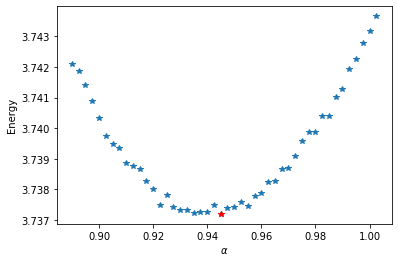

In [1023]:
#Energy as a function of variational paramater alpha
fig5_5,ax5_5 = plt.subplots()
ax5_5.plot(alpha1_2,EnergyTotal_0,'*')
ax5_5.plot(alphaMinima_0,MinimalEnergy_0,'r*')
ax5_5.set_ylabel("Energy")
ax5_5.set_xlabel(r"$\alpha$")

**And then the second time for $\beta$**

In [1026]:
#Setting up range in beta
temp = np.arange(0.4,1.4,0.02)
beta1_2 = np.arange(0.6,0.7,0.0025)
print(beta1_2)

[0.6    0.6025 0.605  0.6075 0.61   0.6125 0.615  0.6175 0.62   0.6225
 0.625  0.6275 0.63   0.6325 0.635  0.6375 0.64   0.6425 0.645  0.6475
 0.65   0.6525 0.655  0.6575 0.66   0.6625 0.665  0.6675 0.67   0.6725
 0.675  0.6775 0.68   0.6825 0.685  0.6875 0.69   0.6925 0.695  0.6975]


In [1027]:
alpha1_Minimal_0 = 0.945
EnergyTotal2_0 = np.zeros(len(beta1_2))
CounterTotal2_0 = np.zeros(len(beta1_2))
VarianceTotal2_0 = np.zeros(len(beta1_2))
ElectronDistanceTotal2_0 = np.zeros(len(beta1_2))
PotentialEnergyTotal2_0 = np.zeros(len(beta1_2))
start = time.time()
for i in range(len(beta1_2)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega1,alpha1_Minimal_0,beta1_2[i],4.5)
    EnergyTotal2_0[i] = Energy
    CounterTotal2_0[i] = Counter
    VarianceTotal2_0[i] = Variance
    ElectronDistanceTotal2_0[i] = ElectronDistance
    PotentialEnergyTotal2_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 71.98252749443054


In [1029]:
#Finding the minimal energy
MinimalEnergy2_0, electDistMinimalEnergy2_0, betaMinimal2_0, PotEnergyMinimal2_0 = FindMinimalEnergy(EnergyTotal2_0,ElectronDistanceTotal2_0,PotentialEnergyTotal2_0,alpha1_Minimal_0,beta1_2,"beta")
print(MinimalEnergy2_0)
print(betaMinimal2_0,electDistMinimalEnergy2_0)
#Filtered
#EnergyTotal2Filtered = savgol_filter(EnergyTotal2,window_length=7,polyorder=5)
#MinimalEnergy2Filt, electDistMinimalEnergy2Filt, betaMinimal2Filt = FindMinimalEnergy(EnergyTotal2Filtered,ElectronDistanceTotal2,alpha1_Minimal,beta1,"beta")
#print("The minimum in energy is:",MinimalEnergy2Filt)
#print("Beta at that minimum is:",betaMinimal2)
#print("This distance between electrons at that minimum is:",electDistMinimalEnergy2Filt)

3.7361648031651105
0.6074999999999998 1.763176098050588


# Then with $\omega = 0.01$:

In [1030]:
omega2 = 0.01
alpha2 = np.arange(0.2,1,0.02)
stepsize2 = np.arange(30,75,0.25)
StepSize2 = FindStepsize(stepsize2,alpha2,omega2)

In [1031]:
print(StepSize2)

[72.    70.125 69.125 68.    67.125 65.625 65.125 64.125 63.375 63.125
 62.    61.625 60.625 60.375 59.875 59.5   58.875 58.5   57.875 56.625
 55.125 54.75  53.375 53.25  52.75  51.5   50.25  50.125 49.375 49.
 48.5   47.625 46.875 46.5   45.625 45.125 44.75  44.125 43.75  43.875]


In [1036]:
omega2 = 0.01
EnergyTotal3 = np.zeros(len(alpha2))
CounterTotal3 = np.zeros(len(alpha2))
VarianceTotal3 = np.zeros(len(alpha2))
ElectronDistanceTotal3 = np.zeros(len(alpha2))
PotentialEnergyTotal3 = np.zeros(len(alpha2))
start = time.time()
for i in range(len(alpha2)):
    stepTemp = StepSize2[i]
    alphaTemp = alpha2[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(2e6),omega2,alphaTemp,stepTemp)
    EnergyTotal3[i] = Energy
    CounterTotal3[i] = Counter
    VarianceTotal3[i] = Variance
    ElectronDistanceTotal3[i] = ElectronDistance
    PotentialEnergyTotal3[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 110.91476106643677


In [1037]:
#Finding the lowest energy
MinimalEnergy3, electDistMinimalEnergy3, alphaMinimal3, PotEnergyMinimal3 = FindMinimalEnergy(EnergyTotal3,ElectronDistanceTotal3,PotentialEnergyTotal3,alpha2,1,"alpha")
print("The minimal energy is:",MinimalEnergy3)
print("The minimal energy is at alpha =",alphaMinimal3)
print("There the distance between electrons is:",electDistMinimalEnergy3)
print("The Potential Energy at that position is:", PotEnergyMinimal3)

The minimal energy is: 0.09360562377714098
The minimal energy is at alpha = 0.4399999999999999
There the distance between electrons is: 24.060016048348505
The Potential Energy at that position is: 0.08700180031575422


**Plotting:**

Text(0.5, 0, '$\\alpha$')

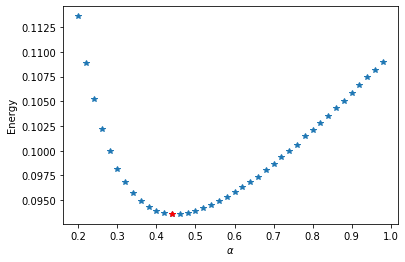

In [1038]:
#Energy as a function of variational paramater alpha
fig6_1,ax6_1 = plt.subplots()
ax6_1.plot(alpha2,EnergyTotal3,'*')
ax6_1.plot(alphaMinimal3,MinimalEnergy3,'r*')
ax6_1.set_ylabel("Energy")
ax6_1.set_xlabel(r"$\alpha$")

Text(0.5, 0, '$\\alpha$')

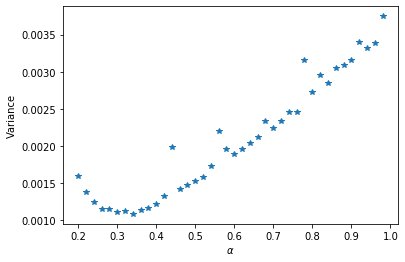

In [1039]:
#Variance as a function of variational parameter alpha
fig6_2,ax6_2 = plt.subplots()
ax6_2.plot(alpha2,VarianceTotal3,'*')
ax6_2.set_ylabel("Variance")
ax6_2.set_xlabel(r"$\alpha$")

**Then analysis for the second trial wave function using the optimal $\alpha$ obtained:**

In [1057]:
#Setting up range in beta
beta2 = np.arange(0.05,0.2,0.0025)
print(beta2)

[0.05   0.0525 0.055  0.0575 0.06   0.0625 0.065  0.0675 0.07   0.0725
 0.075  0.0775 0.08   0.0825 0.085  0.0875 0.09   0.0925 0.095  0.0975
 0.1    0.1025 0.105  0.1075 0.11   0.1125 0.115  0.1175 0.12   0.1225
 0.125  0.1275 0.13   0.1325 0.135  0.1375 0.14   0.1425 0.145  0.1475
 0.15   0.1525 0.155  0.1575 0.16   0.1625 0.165  0.1675 0.17   0.1725
 0.175  0.1775 0.18   0.1825 0.185  0.1875 0.19   0.1925 0.195  0.1975
 0.2   ]


In [1058]:
#Finding the right stepsize
stepsize = np.arange(40,80,0.5)
StepSize3 = FindStepsize2(stepsize,0.44,beta2,0.01)
print(StepSize3)

[68.5  68.   68.25 69.   68.5  68.5  67.5  67.75 67.75 67.5  68.25 67.5
 67.5  67.5  67.25 67.75 67.25 66.75 67.5  68.25 67.5  67.   67.   67.25
 66.5  67.   66.5  66.75 67.25 66.75 66.5  67.   66.5  66.5  66.75 65.75
 66.75 66.   66.   66.25 66.25 65.5  66.25 66.75 66.   66.   65.75 66.25
 66.5  65.75 65.   65.75 64.75 66.25 66.   65.5  65.75 65.5  65.25 64.5
 65.  ]


In [1059]:
omega = 0.01
alpha2 = 0.44
EnergyTotal4 = np.zeros(len(beta2))
CounterTotal4 = np.zeros(len(beta2))
VarianceTotal4 = np.zeros(len(beta2))
ElectronDistanceTotal4 = np.zeros(len(beta2))
PotentialEnergyTotal4 = np.zeros(len(beta2))
start = time.time()
for i in range(len(beta2)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(2e6),omega,alpha2,beta2[i],StepSize3[i])
    EnergyTotal4[i] = Energy
    CounterTotal4[i] = Counter
    VarianceTotal4[i] = Variance
    ElectronDistanceTotal4[i] = ElectronDistance
    PotentialEnergyTotal4[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 220.1136598587036


In [1060]:
#Finding the minimal energy
MinimalEnergy4, electDistMinimalEnergy4, betaMinimal4, PotEnergyMinimal4 = FindMinimalEnergy(EnergyTotal4,ElectronDistanceTotal4,PotentialEnergyTotal4,alpha2,beta2,"beta")
print("The minimal in energy is",MinimalEnergy4)
print("At the minimum the position in beta is",betaMinimal4)
print("At that minimum the distance between electrons is:",electDistMinimalEnergy4)

The minimal in energy is 0.08595106701775097
At the minimum the position in beta is 0.10500000000000005
At that minimum the distance between electrons is: 31.28802156034327


Text(0, 0.5, 'Energy')

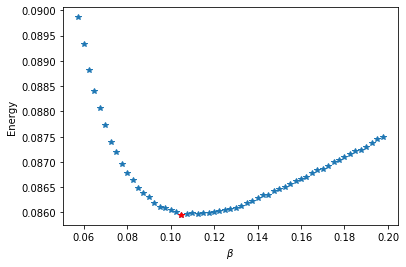

In [1061]:
#plotting Energy as a function of Beta
fig6_3,ax6_3 = plt.subplots()
ax6_3.plot(beta2[3:-1],EnergyTotal4[3:-1],'*')
ax6_3.plot(betaMinimal4,MinimalEnergy4,'r*')
ax6_3.set_xlabel(r"$\beta$")
ax6_3.set_ylabel("Energy")

**Second time for $\alpha$:**

In [1070]:
omega2 = 0.01
alpha2_0 = np.arange(0.45,0.9,0.01)
print(alpha2_0)

[0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58
 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72
 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86
 0.87 0.88 0.89]


In [1071]:
stepsize2_0 = np.arange(30,75,0.25)
StepSize2_0 = FindStepsize(stepsize2_0,alpha2_0,omega2)

In [1072]:
omega2 = 0.01
beta2_Minimal = 0.105
EnergyTotal3_0 = np.zeros(len(alpha2_0))
CounterTotal3_0 = np.zeros(len(alpha2_0))
VarianceTotal3_0 = np.zeros(len(alpha2_0))
ElectronDistanceTotal3_0 = np.zeros(len(alpha2_0))
PotentialEnergyTotal3_0 = np.zeros(len(alpha2_0))
start = time.time()
for i in range(len(alpha2_0)):
    stepTemp = StepSize2_0[i]
    alphaTemp = alpha2_0[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(2e6),omega2,alphaTemp,beta2_Minimal,stepTemp)
    EnergyTotal3_0[i] = Energy
    CounterTotal3_0[i] = Counter
    VarianceTotal3_0[i] = Variance
    ElectronDistanceTotal3_0[i] = ElectronDistance
    PotentialEnergyTotal3_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 168.59577083587646


In [1073]:
#Finding the lowest energy
MinimalEnergy3_0, electDistMinimalEnergy3_0, alphaMinimal3_0, PotEnergyMinimal3_0 = FindMinimalEnergy(EnergyTotal3_0,ElectronDistanceTotal3_0,PotentialEnergyTotal3_0,alpha2_0,1,"alpha")
print("The minimal energy is:",MinimalEnergy3_0)
print("The minimal energy is at alpha =",alphaMinimal3_0)
print("There the distance between electrons is:",electDistMinimalEnergy3_0)
print("The Potential Energy at that position is:", PotEnergyMinimal3_0)

The minimal energy is: 0.08212761094276408
The minimal energy is at alpha = 0.6700000000000002
There the distance between electrons is: 25.785439287355512
The Potential Energy at that position is: 0.07287725139011093


Text(0.5, 0, '$\\alpha$')

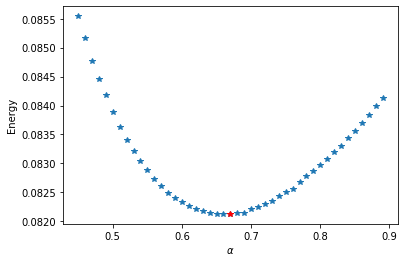

In [1074]:
#Energy as a function of variational paramater alpha
fig6_4,ax6_4 = plt.subplots()
ax6_4.plot(alpha2_0,EnergyTotal3_0,'*')
ax6_4.plot(alphaMinimal3_0,MinimalEnergy3_0,'r*')
ax6_4.set_ylabel("Energy")
ax6_4.set_xlabel(r"$\alpha$")

**Again for $\beta$:**

In [1085]:
#Setting up range in beta
beta2_0 = np.arange(0.04,0.08,0.0015)
print(beta2_0)

[0.04   0.0415 0.043  0.0445 0.046  0.0475 0.049  0.0505 0.052  0.0535
 0.055  0.0565 0.058  0.0595 0.061  0.0625 0.064  0.0655 0.067  0.0685
 0.07   0.0715 0.073  0.0745 0.076  0.0775 0.079 ]


In [1086]:
#Finding the right stepsize
stepsize_0 = np.arange(40,80,0.5)
StepSize3_0 = FindStepsize2(stepsize,0.67,beta2_0,0.01)
print(StepSize3_0)

[56.5  56.25 56.   56.   56.   55.75 55.75 55.75 56.5  55.   56.25 56.5
 55.5  55.25 55.   55.   55.25 55.5  55.25 55.5  55.25 55.   54.75 55.25
 55.   55.75 55.  ]


In [1087]:
omega = 0.01
alpha2_Minimal = 0.67
EnergyTotal4_0 = np.zeros(len(beta2_0))
CounterTotal4_0 = np.zeros(len(beta2_0))
VarianceTotal4_0 = np.zeros(len(beta2_0))
ElectronDistanceTotal4_0 = np.zeros(len(beta2_0))
PotentialEnergyTotal4_0 = np.zeros(len(beta2_0))
start = time.time()
for i in range(len(beta2_0)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(2e6),omega,alpha2_Minimal,beta2_0[i],StepSize3_0[i])
    EnergyTotal4_0[i] = Energy
    CounterTotal4_0[i] = Counter
    VarianceTotal4_0[i] = Variance
    ElectronDistanceTotal4_0[i] = ElectronDistance
    PotentialEnergyTotal4_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 95.87823367118835


In [1190]:
#Finding the minimal energy
MinimalEnergy4_0, electDistMinimalEnergy4_0, betaMinimal4_0, PotEnergyMinimal4_0 = FindMinimalEnergy(EnergyTotal4_0,ElectronDistanceTotal4_0,PotentialEnergyTotal4_0,alpha2_Minimal,beta2_0,"beta")
print("The minimal in energy is",MinimalEnergy4_0)
print("At the minimum the position in beta is",betaMinimal4_0)
print("At that minimum the distance between electrons is:",electDistMinimalEnergy4_0)
print("There the potential Energy is:",PotEnergyMinimal4_0)

The minimal in energy is 0.08057281968423592
At the minimum the position in beta is 0.06700000000000003
At that minimum the distance between electrons is: 29.60800191276884
There the potential Energy is: 0.07156439817848091


Text(0, 0.5, 'Energy')

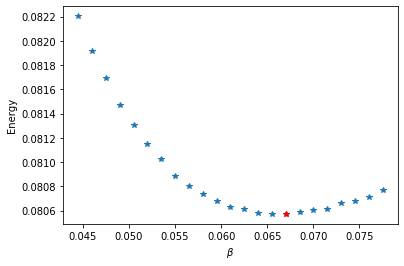

In [1089]:
#plotting Energy as a function of Beta
fig6_5,ax6_5 = plt.subplots()
ax6_5.plot(beta2_0[3:-1],EnergyTotal4_0[3:-1],'*')
ax6_5.plot(betaMinimal4_0,MinimalEnergy4_0,'r*')
ax6_5.set_xlabel(r"$\beta$")
ax6_5.set_ylabel("Energy")

# Then with $\omega = 0.5$:

In [958]:
omega3 = 0.5
alpha3 = np.arange(0.2,2,0.02)
stepsize3 = np.arange(0,10,0.05)
StepSize3 = FindStepsize(stepsize3,alpha3,omega3)

In [959]:
EnergyTotal5 = np.zeros(len(alpha3))
CounterTotal5 = np.zeros(len(alpha3))
VarianceTotal5 = np.zeros(len(alpha3))
ElectronDistanceTotal5 = np.zeros(len(alpha3))
PotentialEnergyTotal5 = np.zeros(len(alpha3))
start = time.time()
for i in range(len(alpha3)):
    stepTemp = StepSize3[i]
    alphaTemp = alpha3[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(1e6),omega3,alphaTemp,stepTemp)
    EnergyTotal5[i] = Energy
    CounterTotal5[i] = Counter
    VarianceTotal5[i] = Variance
    ElectronDistanceTotal5[i] = ElectronDistance
    PotentialEnergyTotal5[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 117.50904297828674


In [960]:
#Finding the lowest energy
MinimalEnergy5, electDistMinimalEnergy5, alphaMinimal5, PotEnergyMinimal5 = FindMinimalEnergy(EnergyTotal5,ElectronDistanceTotal5,PotentialEnergyTotal5,alpha3,1,"alpha")
print("The minimal energy is:",MinimalEnergy5)
print("The minimal energy is at alpha =",alphaMinimal5)
print("There the distance between electrons is:",electDistMinimalEnergy5)
print("At the minimum the potential energy is:",PotEnergyMinimal5)

The minimal energy is: 2.0400307056647056
The minimal energy is at alpha = 0.8399999999999996
There the distance between electrons is: 2.462966104617315
At the minimum the potential energy is: 1.4102428880756577


Text(0, 0.5, 'Energy')

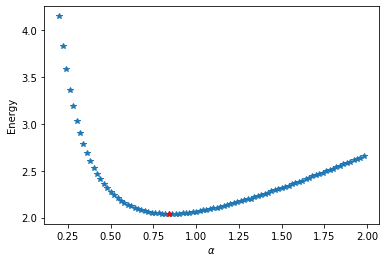

In [689]:
#Energy as a function of variational paramater alpha
fig7, ax7 = plt.subplots()
ax7.plot(alpha3,EnergyTotal5,'*')
ax7.plot(alphaMinimal5,MinimalEnergy5,'r*')
ax7.set_xlabel(r"$\alpha$")
ax7.set_ylabel("Energy")

Text(0.5, 0, '$\\alpha$')

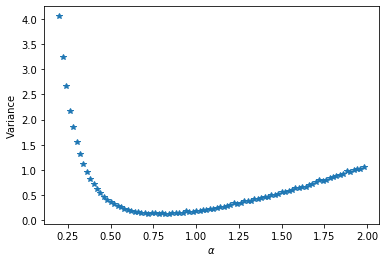

In [690]:
#Variance as a function of variational parameter alpha
fig7_2,ax7_2 = plt.subplots()
ax7_2.plot(alpha1,VarianceTotal5,'*')
ax7_2.set_ylabel("Variance")
ax7_2.set_xlabel(r"$\alpha$")

**Then for variational parameter $\beta$:**

In [697]:
#Setting up range in beta
temp = np.arange(0.2,0.8,0.02)
beta1 = np.arange(0.02,3,0.2)
beta1 = np.concatenate((temp,beta1),axis=0)
beta3 = np.sort(beta1)
print(beta3)

[0.02 0.2  0.22 0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42
 0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.62 0.64 0.66
 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 1.02 1.22 1.42 1.62 1.82 2.02
 2.22 2.42 2.62 2.82]


In [698]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize4 = FindStepsize2(stepsize,0.84,beta3,omega3)
print(StepSize4)

[7.4 6.9 6.8 6.7 6.8 6.9 6.9 7.  6.8 6.8 6.7 6.7 6.9 6.8 6.8 6.9 6.7 6.7
 6.7 6.6 6.8 6.5 6.5 6.7 6.6 6.6 6.7 6.6 6.5 6.6 6.6 6.7 6.5 6.6 6.6 6.5
 6.5 6.5 6.5 6.2 6.4 6.4 6.4 6.5 6.6 6.4]


In [699]:
alpha3 = 0.84
EnergyTotal6 = np.zeros(len(beta3))
CounterTotal6 = np.zeros(len(beta3))
VarianceTotal6 = np.zeros(len(beta3))
ElectronDistanceTotal6 = np.zeros(len(beta3))
start = time.time()
for i in range(len(beta3)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(1e6),omega3,alpha3,beta3[i],StepSize4[i])
    EnergyTotal6[i] = Energy
    CounterTotal6[i] = Counter
    VarianceTotal6[i] = Variance
    ElectronDistanceTotal6[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 80.72088384628296


In [700]:
#Finding the minimal energy
MinimalEnergy6, electDistMinimalEnergy6, betaMinimal6 = FindMinimalEnergy(EnergyTotal6,ElectronDistanceTotal6,alpha2,beta3,"beta")
print("The minimum in energy is :",MinimalEnergy6)
print("Beta at that minimum is:",betaMinimal6)
print("The electron distance at the minimum is",electDistMinimalEnergy6)

The minimum in energy is : 2.0128596173272544
Beta at that minimum is: 0.41999999999999993
The electron distance at the minimum is 2.7177013829051084


Text(0, 0.5, 'Energy')

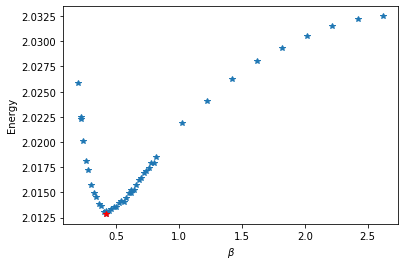

In [702]:
#plotting Energy as a function of Beta
fig7_3,ax7_3 = plt.subplots()
ax7_3.plot(beta3[1:-1],EnergyTotal6[1:-1],'*')
ax7_3.plot(betaMinimal6,MinimalEnergy6,'r*')
ax7_3.set_xlabel(r"$\beta$")
ax7_3.set_ylabel("Energy")

**Again for $\alpha$:**

In [1094]:
alpha3_0 = np.arange(0.5,1.25,0.02)
print(alpha3_0)

[0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76
 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04
 1.06 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24]


In [1095]:
stepsize3_0 = np.arange(0,10,0.05)
StepSize3_0 = FindStepsize(stepsize3,alpha3,omega3)

In [1096]:
beta3_Minimal = 0.42
EnergyTotal5_0 = np.zeros(len(alpha3_0))
CounterTotal5_0 = np.zeros(len(alpha3_0))
VarianceTotal5_0 = np.zeros(len(alpha3_0))
ElectronDistanceTotal5_0 = np.zeros(len(alpha3_0))
PotentialEnergyTotal5_0 = np.zeros(len(alpha3_0))
start = time.time()
for i in range(len(alpha3_0)):
    stepTemp = StepSize3_0[i]
    alphaTemp = alpha3_0[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega3,alphaTemp,beta3_Minimal,stepTemp)
    EnergyTotal5_0[i] = Energy
    CounterTotal5_0[i] = Counter
    VarianceTotal5_0[i] = Variance
    ElectronDistanceTotal5_0[i] = ElectronDistance
    PotentialEnergyTotal5_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 67.59955930709839


In [1097]:
#Finding the lowest energy
MinimalEnergy5_0, electDistMinimalEnergy5_0, alphaMinimal5_0, PotEnergyMinimal5_0 = FindMinimalEnergy(EnergyTotal5_0,ElectronDistanceTotal5_0,PotentialEnergyTotal5_0,alpha3_0,1,"alpha")
print("The minimal energy is:",MinimalEnergy5_0)
print("The minimal energy is at alpha =",alphaMinimal5_0)
print("There the distance between electrons is:",electDistMinimalEnergy5_0)
print("At the minimum the potential energy is:",PotEnergyMinimal5_0)

The minimal energy is: 2.00503064813686
The minimal energy is at alpha = 0.9200000000000004
There the distance between electrons is: 2.6014483803367923
At the minimum the potential energy is: 1.3611579616898861


Text(0, 0.5, 'Energy')

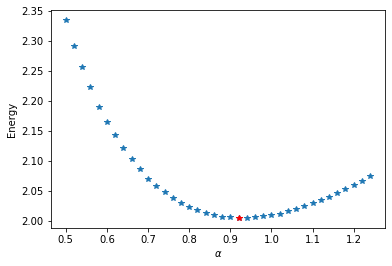

In [1098]:
#Energy as a function of variational paramater alpha
fig7_4, ax7_4 = plt.subplots()
ax7_4.plot(alpha3_0,EnergyTotal5_0,'*')
ax7_4.plot(alphaMinimal5_0,MinimalEnergy5_0,'r*')
ax7_4.set_xlabel(r"$\alpha$")
ax7_4.set_ylabel("Energy")

**And again for $\beta$:**

In [1103]:
#Setting up range in beta
beta3_0 = np.arange(0.25,0.75,0.01)
print(beta3_0)

[0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38
 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52
 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66
 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74]


In [1104]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize4_0 = FindStepsize2(stepsize,0.84,beta3_0,omega3)
print(StepSize4_0)

[6.9 6.9 6.7 6.9 7.  6.9 6.8 6.7 6.7 6.8 6.7 6.7 6.7 6.7 6.6 6.6 6.6 6.7
 6.7 6.7 6.7 6.8 6.9 6.7 6.7 6.6 6.8 6.7 6.6 6.5 6.7 6.6 6.5 6.6 6.7 6.7
 6.6 6.5 6.6 6.6 6.7 6.7 6.6 6.7 6.5 6.5 6.7 6.6 6.6 6.6]


In [1106]:
alpha3_0 = 0.92
EnergyTotal6_0 = np.zeros(len(beta3_0))
CounterTotal6_0 = np.zeros(len(beta3_0))
VarianceTotal6_0 = np.zeros(len(beta3_0))
ElectronDistanceTotal6_0 = np.zeros(len(beta3_0))
PotentialEnergyTotal6_0 = np.zeros(len(beta3_0))
start = time.time()
for i in range(len(beta3_0)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega3,alpha3_0,beta3_0[i],StepSize4_0[i])
    EnergyTotal6_0[i] = Energy
    CounterTotal6_0[i] = Counter
    VarianceTotal6_0[i] = Variance
    ElectronDistanceTotal6_0[i] = ElectronDistance
    PotentialEnergyTotal6_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 87.71915531158447


In [1109]:
#Finding the minimal energy
MinimalEnergy6_0, electDistMinimalEnergy6_0, betaMinimal6_0, PotEnergyMinimal6_0 = FindMinimalEnergy(EnergyTotal6_0,ElectronDistanceTotal6_0,PotentialEnergyTotal6_0,alpha3_0,beta3_0,"beta")
print("The minimum in energy is :",MinimalEnergy6_0)
print("Beta at that minimum is:",betaMinimal6_0)
print("The electron distance at the minimum is",electDistMinimalEnergy6_0)

The minimum in energy is : 2.002715170697718
Beta at that minimum is: 0.29000000000000004
The electron distance at the minimum is 2.6919737631791674


# Analysis of $\omega = 0.25$ to check agains article: 

In [962]:
omega4 = 0.25
alpha4 = np.arange(0.2,2,0.02)
stepsize4 = np.arange(0,40,0.5)
StepSize4 = FindStepsize(stepsize4,alpha4,omega4)

In [963]:
print(StepSize4)

[19.25 18.25 17.5  16.75 16.25 15.75 15.25 15.   14.5  14.25 13.5  13.5
 13.25 12.75 12.25 12.25 12.   11.5  11.5  11.25 11.   11.25 11.25 10.5
 10.5  10.25 10.   10.25  9.75  9.75  9.75  9.5   9.5   9.25  9.25  9.25
  9.    8.75  8.75  8.5   8.5   8.75  8.5   8.5   8.5   8.    8.    8.
  8.    8.    8.    7.75  7.75  7.5   7.75  7.75  7.5   7.25  7.25  7.25
  7.    7.25  7.    7.    7.25  7.    7.25  7.25  6.75  6.75  6.75  6.75
  7.    6.5   6.5   6.75  6.5   6.5   6.5   6.5   6.5   6.25  6.5   6.5
  6.25  6.5   6.25  6.25  6.    6.25]


In [964]:
EnergyTotal7 = np.zeros(len(alpha4))
CounterTotal7 = np.zeros(len(alpha4))
VarianceTotal7 = np.zeros(len(alpha4))
ElectronDistanceTotal7 = np.zeros(len(alpha4))
PotentialEnergyTotal7 = np.zeros(len(alpha4))
start = time.time()
for i in range(len(alpha4)):
    stepTemp = StepSize4[i]
    alphaTemp = alpha4[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(1e6),omega4,alphaTemp,stepTemp)
    EnergyTotal7[i] = Energy
    CounterTotal7[i] = Counter
    VarianceTotal7[i] = Variance
    ElectronDistanceTotal7[i] = ElectronDistance
    PotentialEnergyTotal7[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 107.92413139343262


In [966]:
#Finding the lowest energy
MinimalEnergy7, electDistMinimalEnergy7, alphaMinimal7, PotEnergyMinimal7 = FindMinimalEnergy(EnergyTotal7,ElectronDistanceTotal7,PotentialEnergyTotal7,alpha1,1,"alpha")
print("The minimal energy is:",MinimalEnergy7)
print("The minimal energy is at alpha =",alphaMinimal7)
print("There the distance between electrons is:",electDistMinimalEnergy7)
print("There the potential energy is",PotEnergyMinimal7)

The minimal energy is: 1.1255795639663753
The minimal energy is at alpha = 0.7999999999999996
There the distance between electrons is: 3.5658542428598317
There the potential energy is 0.8250581837269761


Text(0, 0.5, 'Variance')

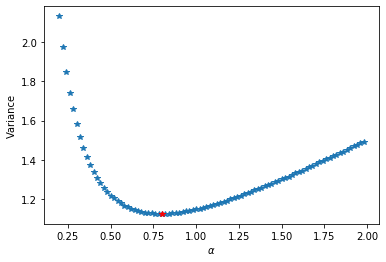

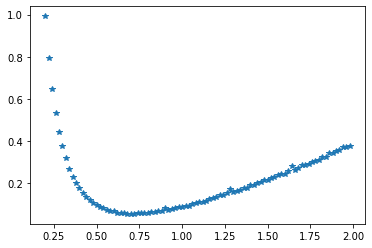

In [751]:
#Energy as a function of variational paramater alpha
fig8, ax8 = plt.subplots()
ax8.plot(alpha1,EnergyTotal7,'*')
ax8.plot(alphaMinimal7,MinimalEnergy7,'r*')
ax8.set_xlabel(r"$\alpha$")
ax8.set_ylabel("Energy")
#Variance
#Energy as a function of variational paramater alpha
fig8_1, ax8_1 = plt.subplots()
ax8_1.plot(alpha1,VarianceTotal7,'*')
ax8.set_xlabel(r"$\alpha$")
ax8.set_ylabel("Variance")

**Then for variational parameter $\beta$:**

In [713]:
#Setting up range in beta
temp = np.arange(0.002,2,0.2)
beta1 = np.arange(0.1,0.4,0.002)
beta1 = np.concatenate((temp,beta1),axis=0)
beta4 = np.sort(beta1)
print(beta4)

[0.002 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.202 0.204 0.206 0.208 0.21  0.212 0.214
 0.216 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238
 0.24  0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262
 0.264 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286
 0.288 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31
 0.312 0.314 0.316 0.318 0.32  0.322 0.324 0.326 0.328 0.33  0.332 0.334
 0.336 0.338 0.34  0.342 0.344 0.346 0.348 0.35  0.352 0.354 0.356 0.358
 0.36  0.362 0.364 0.366 0.368 0.37  0.372 0.374 0.376 0.378 0.38  0.382
 0.384 0.386 0.388 0.39  0.392 0.394 0.396 0.398 0.4   0.402 0.602 0.802
 1.002 1.202 1.402 1.602 1.802]


In [714]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize4 = FindStepsize2(stepsize,0.8,beta4,1)
print(StepSize4)

[5.4 5.1 5.1 5.1 5.  5.  5.1 5.1 5.1 5.  5.1 5.  5.  5.  5.1 5.  5.1 5.1
 5.1 5.1 5.  5.  5.  5.  5.  5.  4.9 5.  5.  5.  5.  5.  4.9 4.9 5.  5.
 5.1 5.  4.9 4.9 4.9 5.  5.  5.  4.8 5.  5.1 4.9 5.  4.9 4.8 5.1 4.9 5.
 5.  5.1 5.  5.1 4.9 5.  4.9 4.9 4.9 4.9 5.  4.8 5.  5.1 5.  5.  5.  5.
 4.9 5.  4.9 5.  4.8 5.  4.9 4.9 4.8 5.  4.9 4.8 4.9 5.  4.9 4.9 5.  5.
 4.9 4.8 4.9 5.  4.8 4.9 4.9 4.9 5.  4.8 4.9 4.9 5.  5.  5.  4.9 4.9 4.9
 4.8 4.8 4.9 4.9 4.9 4.9 4.8 5.  4.8 4.8 4.9 4.9 4.7 4.9 4.8 4.9 4.9 4.8
 4.9 5.  4.9 4.9 4.8 5.  5.  4.8 5.  4.9 4.9 4.8 4.9 4.9 4.8 4.8 4.8 4.8
 4.8 4.8 5.  4.9 4.9 4.9 4.9 4.8 4.8 4.9 4.8 4.8 4.8 4.8 4.8 4.6 4.7]


In [715]:
omega4 = 0.25
alpha4 = 0.8
EnergyTotal8 = np.zeros(len(beta4))
CounterTotal8 = np.zeros(len(beta4))
VarianceTotal8 = np.zeros(len(beta4))
ElectronDistanceTotal8 = np.zeros(len(beta4))
start = time.time()
for i in range(len(beta4)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(1e6),omega4,alpha4,beta4[i],StepSize4[i])
    EnergyTotal8[i] = Energy
    CounterTotal8[i] = Counter
    VarianceTotal8[i] = Variance
    ElectronDistanceTotal8[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 277.67400455474854


In [718]:
#Finding the minimal energy
EnergyTotal8Filtered = savgol_filter(EnergyTotal8,window_length=5,polyorder=3)
MinimalEnergy8, electDistMinimalEnergy8, betaMinimal8 = FindMinimalEnergy(EnergyTotal8,ElectronDistanceTotal8,alpha4,beta4,"beta")
print("The minimum in energy is :",MinimalEnergy8)
print("Beta at that minimum is:",betaMinimal8)
print("The electron distance at the minimum is",electDistMinimalEnergy8)
MinimalEnergy8Filt, electDistMinimalEnergy8Filt, betaMinimal8Filt = FindMinimalEnergy(EnergyTotal8Filtered,ElectronDistanceTotal8,alpha2,beta4,"beta")
print("The minimum in energy is (Filtered):",MinimalEnergy8Filt)
print("Beta at that minimum is (Filtered):",betaMinimal8Filt)
print("The electron distance at the minimum is (Filtered)",electDistMinimalEnergy8Filt)

The minimum in energy is : 1.0999148076438836
Beta at that minimum is: 0.3240000000000002
The electron distance at the minimum is 4.0456760555373
The minimum in energy is (Filtered): 1.0999637389270445
Beta at that minimum is (Filtered): 0.3240000000000002
The electron distance at the minimum is (Filtered) 4.0456760555373


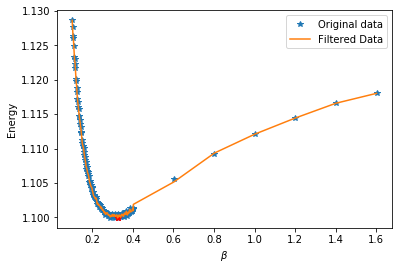

In [717]:
#plotting Energy as a function of Beta
fig8_3,ax8_3 = plt.subplots()
ax8_3.plot(beta4[1:-1],EnergyTotal8[1:-1],'*',label="Original data")#Spurning um að nota einhver filter til að ná út suði
ax8_3.plot(betaMinimal8,MinimalEnergy8,'r*')
ax8_3.plot(betaMinimal8Filt,MinimalEnergy8Filt,'r*')
ax8_3.set_xlabel(r"$\beta$")
ax8_3.set_ylabel("Energy")
#Trying to filter the data
MinimalEnergy8Filtered = savgol_filter(EnergyTotal8[1:-1],window_length=7,polyorder=5)
ax8_3.plot(beta4[1:-1],MinimalEnergy8Filtered,label="Filtered Data")
ax8_3.legend()

**Again for $\alpha$:**

In [1112]:
omega4 = 0.25
alpha4_0 = np.arange(0.5,1.25,0.01)
print(alpha4_0)

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05
 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19
 1.2  1.21 1.22 1.23 1.24]


In [1113]:
stepsize4_0 = np.arange(0,40,0.5)
StepSize4_0 = FindStepsize(stepsize4,alpha4,omega4)

In [1114]:
beta4_Minimal = 0.324
EnergyTotal7_0 = np.zeros(len(alpha4_0))
CounterTotal7_0 = np.zeros(len(alpha4_0))
VarianceTotal7_0 = np.zeros(len(alpha4_0))
ElectronDistanceTotal7_0 = np.zeros(len(alpha4_0))
PotentialEnergyTotal7_0 = np.zeros(len(alpha4_0))
start = time.time()
for i in range(len(alpha4_0)):
    stepTemp = StepSize4_0[i]
    alphaTemp = alpha4_0[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega4,alphaTemp,beta4_Minimal,stepTemp)
    EnergyTotal7_0[i] = Energy
    CounterTotal7_0[i] = Counter
    VarianceTotal7_0[i] = Variance
    ElectronDistanceTotal7_0[i] = ElectronDistance
    PotentialEnergyTotal7_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 133.92133569717407


In [1115]:
#Finding the lowest energy
MinimalEnergy7_0, electDistMinimalEnergy7_0, alphaMinimal7_0, PotEnergyMinimal7_0 = FindMinimalEnergy(EnergyTotal7_0,ElectronDistanceTotal7_0,PotentialEnergyTotal7_0,alpha4_0,1,"alpha")
print("The minimal energy is:",MinimalEnergy7_0)
print("The minimal energy is at alpha =",alphaMinimal7_0)
print("There the distance between electrons is:",electDistMinimalEnergy7_0)
print("There the potential energy is",PotEnergyMinimal7_0)

The minimal energy is: 1.0943621937129484
The minimal energy is at alpha = 0.9100000000000004
There the distance between electrons is: 3.7947167957062238
There the potential energy is 0.7785617330253963


**Again for $\beta$:**

In [1118]:
#Setting up range in beta
beta4_0 = np.arange(0.2,0.5,0.005)
print(beta4_0)

[0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24  0.245 0.25  0.255
 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3   0.305 0.31  0.315
 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36  0.365 0.37  0.375
 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415 0.42  0.425 0.43  0.435
 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475 0.48  0.485 0.49  0.495]


In [1119]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize4_0 = FindStepsize2(stepsize,0.91,beta4_0,1)
print(StepSize4_0)

[4.7 4.6 4.6 4.6 4.6 4.7 4.7 4.5 4.6 4.6 4.5 4.6 4.7 4.5 4.7 4.6 4.7 4.5
 4.6 4.5 4.6 4.6 4.5 4.6 4.5 4.6 4.6 4.6 4.6 4.5 4.6 4.6 4.6 4.5 4.5 4.5
 4.5 4.5 4.6 4.6 4.6 4.5 4.6 4.5 4.6 4.5 4.6 4.6 4.5 4.4 4.5 4.5 4.5 4.6
 4.5 4.5 4.6 4.5 4.6 4.5]


In [1120]:
omega4 = 0.25
alpha4_Minimal = 0.91
EnergyTotal8_0 = np.zeros(len(beta4_0))
CounterTotal8_0 = np.zeros(len(beta4_0))
VarianceTotal8_0 = np.zeros(len(beta4_0))
ElectronDistanceTotal8_0 = np.zeros(len(beta4_0))
PotentialEnergyTotal8_0 = np.zeros(len(beta4_0))
start = time.time()
for i in range(len(beta4_0)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega4,alpha4_Minimal,beta4_0[i],StepSize4_0[i])
    EnergyTotal8_0[i] = Energy
    CounterTotal8_0[i] = Counter
    VarianceTotal8_0[i] = Variance
    ElectronDistanceTotal8_0[i] = ElectronDistance
    PotentialEnergyTotal8_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 105.69120001792908


In [1123]:
MinimalEnergy8_0, electDistMinimalEnergy8_0, betaMinimal8_0, PotEnergyMinimal8_0 = FindMinimalEnergy(EnergyTotal8_0,ElectronDistanceTotal8_0,PotentialEnergyTotal8_0,alpha4_Minimal,beta4_0,"beta")
print("The minimum in energy is :",MinimalEnergy8_0)
print("Beta at that minimum is:",betaMinimal8_0)
print("The electron distance at the minimum is",electDistMinimalEnergy8_0)

The minimum in energy is : 1.0909927644001682
Beta at that minimum is: 0.20500000000000002
The electron distance at the minimum is 4.020555197640189


# Analysis of $\omega = 0.05$ to check agains article: 

In [967]:
omega5 = 0.05
alpha5 = np.arange(0.2,2,0.02)
stepsize5 = np.arange(0,40,0.5)
StepSize5 = FindStepsize(stepsize5,alpha5,omega5)

In [968]:
print(StepSize5)

[35.25 34.75 34.25 33.5  32.75 32.5  32.25 32.   31.25 31.   30.5  29.75
 29.25 28.75 28.   27.25 26.75 26.   25.75 25.5  25.25 24.   24.   23.5
 23.5  23.25 22.75 22.75 22.   22.5  21.5  21.25 21.5  20.25 20.5  20.5
 19.75 19.75 19.5  19.25 19.   18.75 18.75 19.   18.5  18.5  18.   18.25
 17.75 17.75 17.5  17.25 17.25 17.5  17.25 17.   16.5  16.75 16.25 16.
 16.25 16.25 16.25 16.   15.5  15.75 15.75 15.75 15.5  15.25 14.75 15.
 15.   15.   14.75 14.75 15.   14.5  14.75 14.75 14.5  14.   14.25 14.
 13.75 14.   14.   14.   14.   13.75]


In [969]:
EnergyTotal9 = np.zeros(len(alpha5))
CounterTotal9 = np.zeros(len(alpha5))
VarianceTotal9 = np.zeros(len(alpha5))
ElectronDistanceTotal9 = np.zeros(len(alpha5))
PotentialEnergyTotal9 = np.zeros(len(alpha5))
start = time.time()
for i in range(len(alpha5)):
    stepTemp = StepSize5[i]
    alphaTemp = alpha5[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(1e6),omega5,alphaTemp,stepTemp)
    EnergyTotal9[i] = Energy
    CounterTotal9[i] = Counter
    VarianceTotal9[i] = Variance
    ElectronDistanceTotal9[i] = ElectronDistance
    PotentialEnergyTotal9[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 120.52262425422668


In [970]:
#Finding the lowest energy
MinimalEnergy9, electDistMinimalEnergy9, alphaMinimal9, PotEnergyMinimal9 = FindMinimalEnergy(EnergyTotal9,ElectronDistanceTotal9,PotentialEnergyTotal9,alpha5,omega5,"alpha")
print("The minimal energy is:",MinimalEnergy9)
print("The minimal energy is at alpha =",alphaMinimal9)
print("There the distance between electrons is:",electDistMinimalEnergy9)
print("There the potential energy is",PotEnergyMinimal9)

The minimal energy is: 0.30782050389761123
The minimal energy is at alpha = 0.6399999999999998
There the distance between electrons is: 8.92743671957213
There the potential energy is 0.25984238035651025


Text(0, 0.5, 'Energy')

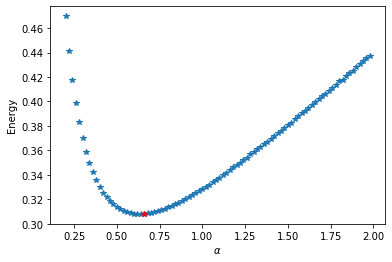

In [730]:
#Energy as a function of variational paramater alpha
fig9, ax9 = plt.subplots()
ax9.plot(alpha5,EnergyTotal9,'*')
ax9.plot(alphaMinimal9,MinimalEnergy9,'r*')
ax9.set_xlabel(r"$\alpha$")
ax9.set_ylabel("Energy")

**Then for $\beta$ based on optimal $\alpha$:**

In [1261]:
#Setting up range in beta
beta5 = np.arange(0.1,0.5,0.005)
print(beta5)

[0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155
 0.16  0.165 0.17  0.175 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215
 0.22  0.225 0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275
 0.28  0.285 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335
 0.34  0.345 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395
 0.4   0.405 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455
 0.46  0.465 0.47  0.475 0.48  0.485 0.49  0.495]


In [1262]:
#Finding the right stepsize
stepsize = np.arange(10,40,0.2)
StepSize5 = FindStepsize2(stepsize,0.64,beta5,omega5)
print(StepSize5)

[25.7 25.4 25.4 25.4 25.1 25.2 25.  25.2 24.9 24.9 25.1 24.9 24.7 24.8
 24.9 24.8 24.7 24.7 24.6 24.4 24.8 24.6 24.6 24.3 24.3 24.3 24.4 24.8
 24.3 24.5 24.6 24.2 24.2 24.6 24.4 24.5 24.6 24.2 24.5 24.3 24.1 24.1
 24.2 24.2 24.1 24.2 23.8 24.2 24.  23.8 24.1 24.3 24.1 24.3 24.1 23.9
 23.9 23.8 24.  23.9 23.9 24.  23.8 24.1 23.9 23.7 23.8 23.6 24.1 24.1
 24.  23.8 24.  23.6 23.9 23.7 24.  24.  23.8 23.7]


In [1263]:
print(len(beta5),len(StepSize5))

80 80


In [1264]:
omega5 = 0.05
alpha5 = 0.64
EnergyTotal10 = np.zeros(len(beta5))
CounterTotal10 = np.zeros(len(beta5))
VarianceTotal10 = np.zeros(len(beta5))
ElectronDistanceTotal10 = np.zeros(len(beta5))
PotentialEnergyTotal10 = np.zeros(len(beta5))
start = time.time()
for i in range(len(beta5)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(5e6),omega5,alpha5,beta5[i],StepSize5[i])
    EnergyTotal10[i] = Energy
    CounterTotal10[i] = Counter
    VarianceTotal10[i] = Variance
    ElectronDistanceTotal10[i] = ElectronDistance
    PotentialEnergyTotal10[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 671.6514668464661


In [1265]:
MinimalEnergy10, electDistMinimalEnergy10, betaMinimal10, PotEnergyMinimal10 = FindMinimalEnergy(EnergyTotal10,ElectronDistanceTotal10,PotentialEnergyTotal10,alpha5,beta5,"beta")
print("The minimum in energy is :",MinimalEnergy10)
print("Beta at that minimum is:",betaMinimal10)
print("The electron distance at the minimum is",electDistMinimalEnergy10)

The minimum in energy is : 0.29165951893106984
Beta at that minimum is: 0.18000000000000008
The electron distance at the minimum is 10.873373978293293


Text(0, 0.5, 'Energy')

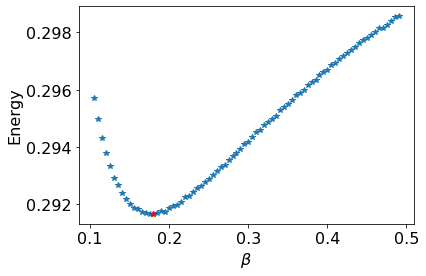

In [1266]:
#plotting Energy as a function of Beta
fig9_2,ax9_2 = plt.subplots()
ax9_2.plot(beta5[1:-1],EnergyTotal10[1:-1],'*',label="Original data")#Spurning um að nota einhver filter til að ná út suði
ax9_2.plot(betaMinimal10,MinimalEnergy10,'r*')
ax9_2.set_xlabel(r"$\beta$")
ax9_2.set_ylabel("Energy")

**Again for $\alpha$:**

In [1257]:
omega5 = 0.05
alpha5_0 = np.arange(0.5,1.25,0.01)
print(alpha5_0)

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05
 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19
 1.2  1.21 1.22 1.23 1.24]


In [1258]:
stepsize5_0 = np.arange(0,40,0.5)
StepSize5_0 = FindStepsize(stepsize5,alpha5_0,omega5)

In [1259]:
beta5_Minimal = 0.70
EnergyTotal9_0 = np.zeros(len(alpha5_0))
CounterTotal9_0 = np.zeros(len(alpha5_0))
VarianceTotal9_0 = np.zeros(len(alpha5_0))
ElectronDistanceTotal9_0 = np.zeros(len(alpha5_0))
PotentialEnergyTotal9_0 = np.zeros(len(alpha5_0))
start = time.time()
for i in range(len(alpha4_0)):
    stepTemp = StepSize5_0[i]
    alphaTemp = alpha5_0[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(1e6),omega5,alphaTemp,beta5_Minimal,stepTemp)
    EnergyTotal9_0[i] = Energy
    CounterTotal9_0[i] = Counter
    VarianceTotal9_0[i] = Variance
    ElectronDistanceTotal9_0[i] = ElectronDistance
    PotentialEnergyTotal9_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 115.97317004203796


In [1260]:
#Finding the lowest energy
MinimalEnergy9_0, electDistMinimalEnergy9_0, alphaMinimal9_0, PotEnergyMinimal9_0 = FindMinimalEnergy(EnergyTotal9_0,ElectronDistanceTotal9_0,PotentialEnergyTotal9_0,alpha5_0,1,"alpha")
print("The minimal energy is:",MinimalEnergy9_0)
print("The minimal energy is at alpha =",alphaMinimal9_0)
print("There the distance between electrons is:",electDistMinimalEnergy9_0)
print("There the potential energy is",PotEnergyMinimal9_0)

The minimal energy is: 0.3013264156865675
The minimal energy is at alpha = 0.6600000000000001
There the distance between electrons is: 9.110678326845026
There the potential energy is 0.25293534681655977


**again for $\beta$:**

In [1267]:
#Setting up range in beta
beta5_0 = np.arange(0.1,0.5,0.005)
print(beta5_0)

[0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155
 0.16  0.165 0.17  0.175 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215
 0.22  0.225 0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275
 0.28  0.285 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335
 0.34  0.345 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395
 0.4   0.405 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455
 0.46  0.465 0.47  0.475 0.48  0.485 0.49  0.495]


In [1268]:
#Finding the right stepsize
stepsize = np.arange(10,40,0.2)
StepSize5_0 = FindStepsize2(stepsize,0.66,beta5_0,omega5)
print(StepSize5_0)

[25.  24.9 25.  24.6 24.9 24.8 24.8 24.6 24.8 25.  24.6 24.9 24.6 24.7
 24.7 24.6 24.3 24.5 24.2 24.4 24.2 24.  23.9 24.1 24.5 23.9 24.1 24.4
 24.1 24.2 23.9 24.1 24.1 23.8 24.  23.9 23.8 24.  23.9 23.9 23.9 24.
 24.  23.8 23.9 24.  23.8 23.7 23.7 23.7 23.7 23.8 23.5 23.8 23.9 23.7
 23.7 23.7 23.7 23.8 23.7 23.7 23.8 23.5 23.3 23.5 23.6 23.5 23.4 23.4
 23.7 23.7 23.5 23.5 23.5 23.5 23.6 23.6 23.4 23.3]


In [1269]:
omega5 = 0.05
alpha5_Minimal = 0.64
EnergyTotal10_0 = np.zeros(len(beta5_0))
CounterTotal10_0 = np.zeros(len(beta5_0))
VarianceTotal10_0 = np.zeros(len(beta5_0))
ElectronDistanceTotal10_0 = np.zeros(len(beta5_0))
PotentialEnergyTotal10_0 = np.zeros(len(beta5_0))
start = time.time()
for i in range(len(beta5_0)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(5e6),omega5,alpha5_Minimal,beta5_0[i],StepSize5_0[i])
    EnergyTotal10_0[i] = Energy
    CounterTotal10_0[i] = Counter
    VarianceTotal10_0[i] = Variance
    ElectronDistanceTotal10_0[i] = ElectronDistance
    PotentialEnergyTotal10_0[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 679.0664641857147


In [1270]:
MinimalEnergy10_0, electDistMinimalEnergy10_0, betaMinimal10_0, PotEnergyMinimal10_0 = FindMinimalEnergy(EnergyTotal10_0,ElectronDistanceTotal10_0,PotentialEnergyTotal10_0,alpha5_Minimal,beta5_0,"beta")
print("The minimum in energy is :",MinimalEnergy10_0)
print("Beta at that minimum is:",betaMinimal10_0)
print("The electron distance at the minimum is",electDistMinimalEnergy10_0)

The minimum in energy is : 0.2916291246160414
Beta at that minimum is: 0.18000000000000008
The electron distance at the minimum is 10.86654722444671


Text(0, 0.5, 'Energy')

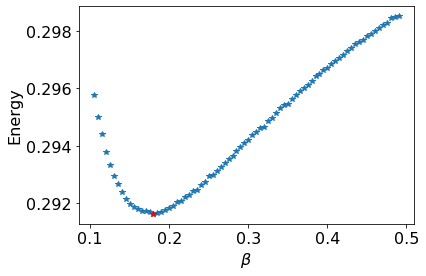

In [1271]:
#plotting Energy as a function of Beta
fig9_3,ax9_3 = plt.subplots()
ax9_3.plot(beta5_0[1:-1],EnergyTotal10_0[1:-1],'*',label="Original data")#Spurning um að nota einhver filter til að ná út suði
ax9_3.plot(betaMinimal10_0,MinimalEnergy10_0,'r*')
ax9_3.set_xlabel(r"$\beta$")
ax9_3.set_ylabel("Energy")

# $\omega = 0.75$

In [1235]:
omega6 = 0.75
alpha6 = np.arange(0.2,2,0.02)
stepsize6 = np.arange(0,40,0.5)
StepSize6 = FindStepsize(stepsize6,alpha6,omega6)

In [1236]:
print(StepSize6)

[10.75 10.5  10.25  9.5   9.25  9.25  8.75  8.5   8.25  8.    8.    7.75
  7.5   7.25  7.25  7.    6.75  6.75  6.5   6.5   6.5   6.25  6.    6.25
  5.75  6.    5.75  6.    5.75  5.75  5.5   5.75  5.25  5.5   5.25  5.5
  5.    5.    5.25  5.    5.    5.    4.75  4.75  5.    4.75  4.75  4.75
  4.5   4.5   4.5   4.5   4.5   4.5   4.5   4.5   4.5   4.5   4.25  4.25
  4.25  4.25  4.    4.    4.    4.    4.    4.    4.    4.    3.75  3.75
  4.    4.    3.75  3.75  3.75  4.    3.75  3.75  3.75  3.75  3.75  3.75
  3.5   3.75  3.5   3.5   3.5   3.75]


In [1237]:
EnergyTotal11 = np.zeros(len(alpha6))
CounterTotal11 = np.zeros(len(alpha6))
VarianceTotal11 = np.zeros(len(alpha6))
ElectronDistanceTotal11 = np.zeros(len(alpha6))
PotentialEnergyTotal11 = np.zeros(len(alpha6))
start = time.time()
for i in range(len(alpha6)):
    stepTemp = StepSize6[i]
    alphaTemp = alpha6[i]
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarloCoulomb(int(1e6),omega6,alphaTemp,stepTemp)
    EnergyTotal11[i] = Energy
    CounterTotal11[i] = Counter
    VarianceTotal11[i] = Variance
    ElectronDistanceTotal11[i] = ElectronDistance
    PotentialEnergyTotal11[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 119.19809484481812


In [1238]:
#Finding the lowest energy
MinimalEnergy11, electDistMinimalEnergy11, alphaMinimal11, PotEnergyMinimal11 = FindMinimalEnergy(EnergyTotal11,ElectronDistanceTotal11,PotentialEnergyTotal11,alpha6,omega6,"alpha")
print("The minimal energy is:",MinimalEnergy11)
print("The minimal energy is at alpha =",alphaMinimal11)
print("There the distance between electrons is:",electDistMinimalEnergy11)
print("There the potential energy is",PotEnergyMinimal11)

The minimal energy is: 2.9170675136104687
The minimal energy is at alpha = 0.8799999999999997
There the distance between electrons is: 1.9644948272682035
There the potential energy is 1.928001503660707


Text(0, 0.5, 'Energy')

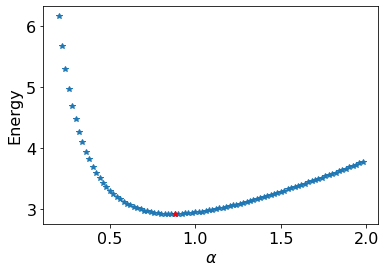

In [1239]:
#Energy as a function of variational paramater alpha
fig11, ax11 = plt.subplots()
ax11.plot(alpha6,EnergyTotal11,'*')
ax11.plot(alphaMinimal11,MinimalEnergy11,'r*')
ax11.set_xlabel(r"$\alpha$")
ax11.set_ylabel("Energy")

**Then for $\beta$ based on optimal $\alpha$:**

In [1272]:
#Setting up range in beta
beta6 = np.arange(0.35,0.65,0.005)
print(beta6)

[0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405
 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465
 0.47  0.475 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525
 0.53  0.535 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585
 0.59  0.595 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645
 0.65 ]


In [1273]:
#Finding the right stepsize
stepsize = np.arange(0,60,0.2)
StepSize7 = FindStepsize2(stepsize,0.88,beta6,omega6)
print(StepSize7)

[5.4 5.3 5.2 5.5 5.2 5.4 5.4 5.3 5.3 5.3 5.2 5.3 5.4 5.5 5.2 5.4 5.3 5.4
 5.4 5.2 5.4 5.4 5.2 5.3 5.5 5.3 5.5 5.3 5.4 5.2 5.3 5.3 5.4 5.2 5.2 5.4
 5.2 5.4 5.3 5.2 5.4 5.3 5.3 5.3 5.3 5.2 5.4 5.2 5.2 5.3 5.3 5.4 5.3 5.4
 5.4 5.3 5.2 5.3 5.2 5.2 5.2]


In [1274]:
omega6 = 0.75
alpha6 = 0.88
EnergyTotal12 = np.zeros(len(beta6))
CounterTotal12 = np.zeros(len(beta6))
VarianceTotal12 = np.zeros(len(beta6))
ElectronDistanceTotal12 = np.zeros(len(beta6))
PotentialEnergyTotal12 = np.zeros(len(beta6))
start = time.time()
for i in range(len(beta6)):
    Energy, Counter, Variance, ElectronDistance, PotEnergy = MonteCarlo2(int(5e6),omega6,alpha6,beta6[i],StepSize7[i])
    EnergyTotal12[i] = Energy
    CounterTotal12[i] = Counter
    VarianceTotal12[i] = Variance
    ElectronDistanceTotal12[i] = ElectronDistance
    PotentialEnergyTotal12[i] = PotEnergy
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 508.78418016433716


In [1275]:
MinimalEnergy12, electDistMinimalEnergy12, betaMinimal12, PotEnergyMinimal12 = FindMinimalEnergy(EnergyTotal12,ElectronDistanceTotal12,PotentialEnergyTotal12,alpha6,beta6,"beta")
print("The minimum in energy is :",MinimalEnergy12)
print("Beta at that minimum is:",betaMinimal12)
print("The electron distance at the minimum is",electDistMinimalEnergy12)

The minimum in energy is : 2.884982752053336
Beta at that minimum is: 0.5050000000000001
The electron distance at the minimum is 2.134634821541271


Text(0, 0.5, 'Energy')

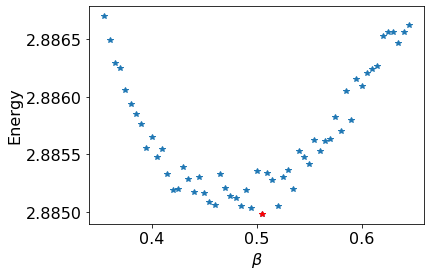

In [1276]:
#plotting Energy as a function of Beta
fig11_2,ax11_2 = plt.subplots()
ax11_2.plot(beta6[1:-1],EnergyTotal12[1:-1],'*',label="Original data")#Spurning um að nota einhver filter til að ná út suði
ax11_2.plot(betaMinimal12,MinimalEnergy12,'r*')
ax11_2.set_xlabel(r"$\beta$")
ax11_2.set_ylabel("Energy")

**again for $\alpha$:**

# Virial Theorem

**Having minimized the energy we can chech the Virial Theorem:**

In [784]:
#Setting up the omega we intend to measure
omegaVirial = np.array([0.01,0.05,0.25,0.5,1])

**First we check for the simple harmonic oscillator with non-interacting electrons:**

$\alpha = 1$ is always a minimum 

In [993]:
omegaVirial = np.arange(0.01,1,0.05)
print(omegaVirial)

[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66
 0.71 0.76 0.81 0.86 0.91 0.96]


In [994]:
PotentialEnergyVirial = np.zeros(len(omegaVirial))
KineticEnergyVirial = np.zeros(len(omegaVirial))
counter = 0
for omegaTemp in omegaVirial:
    Energy, Counter, Variance, PotEnergy = MonteCarlo(int(4e5),omegaTemp,1,3.8)
    PotentialEnergyVirial[counter] = PotEnergy
    KineticEnergyVirial[counter] = Energy - PotEnergy
    counter += 1

**Setting up measured values in vectors:**

In [1192]:
omegaVirial2 = np.array([0.01,0.25,0.5,1])
#Total Energy
EnergyMinimalTotal = np.array([MinimalEnergy4_0,MinimalEnergy8_0,MinimalEnergy6_0,MinimalEnergy2_0])
#Potential Energy
PotEnergyMinimalTotal = np.array([PotEnergyMinimal4_0,PotEnergyMinimal8_0,PotEnergyMinimal6_0,PotEnergyMinimal2_0])
#Kinetic Energy
KineticEnergyTotal = EnergyMinimalTotal - PotEnergyMinimalTotal
#Ratio
KV_Ratio = KineticEnergyTotal/PotEnergyMinimalTotal
#Electron distance without Jastrow factor
ElectronDistwithoutJastrow = np.array([electDistMinimalEnergy3,electDistMinimalEnergy9,electDistMinimalEnergy7,electDistMinimalEnergy5,electDistMinimalEnergy])
#Electron distance with Jastrow factor
ElectronDistwithJastrow = np.array([electDistMinimalEnergy4_0,electDistMinimalEnergy8_0,electDistMinimalEnergy6_0,electDistMinimalEnergy2_0])

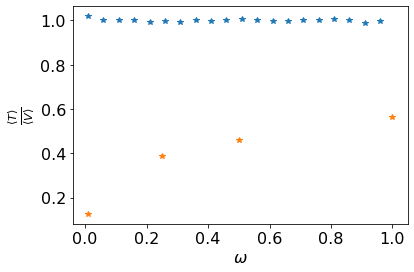

In [1187]:
fig10,ax10 = plt.subplots()
ax10.plot(omegaVirial,KineticEnergyVirial/PotentialEnergyVirial,'*')
ax10.set_ylabel(r"$\frac{\langle T\rangle}{\langle V\rangle}$")
ax10.set_xlabel(r"$\omega$")
#ax10.set_ylim([0,2])
#Taking the ration from the first trial wave function and including the Coulomb potential contribution
ax10.plot(omegaVirial2,KV_Ratio,'*')
plt.show()

0.3286673961243094
-0.5438250357938416


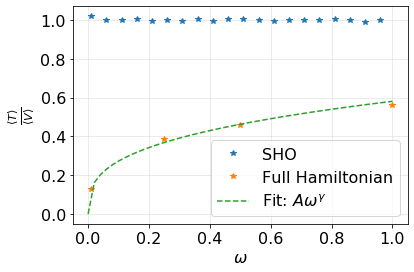

In [1214]:
p = np.polyfit(np.log(omegaVirial2),np.log(KV_Ratio),1)
power = p[0]
print(power)
constant = p[1]
print(constant)
x = np.linspace(0,1)
y = x**power
y = y*np.exp(constant)
#plotta
fig11,ax11 = plt.subplots()
ax11.plot(omegaVirial,KineticEnergyVirial/PotentialEnergyVirial,'*',label="SHO")
ax11.set_ylabel(r"$\frac{\langle T\rangle}{\langle V\rangle}$")
ax11.set_xlabel(r"$\omega$")
ax11.plot(omegaVirial2,KV_Ratio,'*',label="Full Hamiltonian")
ax11.plot(x,y,'--',label=r"Fit: $A\omega^{\gamma}$")
ax11.legend()
ax11.grid(alpha=0.3)
#Saving
plt.savefig("VirialTheorem.png",format="PNG",dpi=300,bbox_inches='tight')

**Distance between electrons:**

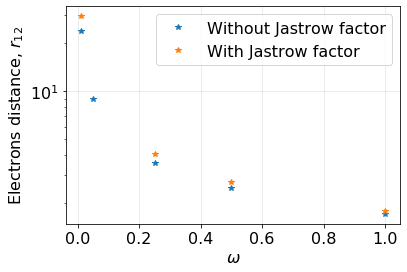

In [1225]:
omegaVirial2_1 = np.array([0.01,0.05,0.25,0.5,1])
fig12,ax12 = plt.subplots()
ax12.plot(omegaVirial2_1,ElectronDistwithoutJastrow,'*',label="Without Jastrow factor")
ax12.plot(omegaVirial2,ElectronDistwithJastrow,'*',label="With Jastrow factor")
ax12.grid(alpha=0.3)
ax12.set_yscale("log")
ax12.legend()
ax12.set_ylabel(r"Electrons distance, $r_{12}$")
ax12.set_xlabel(r"$\omega$")
#Saving
plt.savefig("ElectronDistance.png",format="png",dpi=300,bbox_inches='tight')